INSURANCE CLAIM PREDICTION IN OLUSOLA INSURANCE

Variable	Description
Customer Id	Identification number for the Policy holder
YearOfObservation	year of observation for the insured policy
Insured_Period	duration of insurance policy in Olusola Insurance. (Ex: Full year insurance, Policy Duration = 1; 6 months = 0.5
Residential	is the building a residential building or not
Building_Painted	is the building painted or not (N-Painted, V-Not Painted)
Building_Fenced	is the building fence or not (N-Fenced, V-Not Fenced)
Garden	building has garden or not (V-has garden; O-no garden)
Settlement	Area where the building is located. (R- rural area; U- urban area)
Building Dimension	Size of the insured building in m2
Building_Type	The type of building (Type 1, 2, 3, 4)
Date_of_Occupancy	date building was first occupied
NumberOfWindows	number of windows in the building
Geo Code	Geographical Code of the Insured building
Claim	target variable. (0: no claim, 1: at least one claim over insured period).

In [54]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

In [26]:
#importing data through its directory
df = pd.read_csv("Train_data.csv")
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [27]:
df.shape

(7160, 14)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [29]:
# Reviewing Statiscal Summary of the dataframe
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [30]:
#looking for duplicated records
df.duplicated().sum()

np.int64(0)

In [31]:
# Dropping Irrelevant columns; ID column
df.drop(columns=['Customer Id'], inplace=True)

In [32]:
# confirming removed column
df.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [33]:
#checking for missing values
df.isna().sum()

YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [34]:
#separating categorical and numerical columns
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype != 'object']
print('cat_cols', categorical_cols)
print('num_cols', numerical_cols)

cat_cols ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'NumberOfWindows', 'Geo_Code']
num_cols ['YearOfObservation', 'Insured_Period', 'Residential', 'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'Claim']


HANDLING MISSING DATA

It is observed that four variables have missing values; Garden, Building Dimension, Date of Occupancy and Geo_Code. Hence, they would be addressed by filling the missing record based on their categories. 'Building Dimension' and 'Date of Occupancy' will be filled up with the median of their columns because they are numerical columns while 'Garden column' will be filled with the mode of its column because it is a categoraical variable.

Geo_Code is a high-cardinality categorical identifier without numerical meaning. Handling it like numerical features using mean or median imputation would introduce artificial geographic values. Instead, it will be encoded in a way that preserves category identity without biasing the model. this will be done using Label Encoding

In [35]:
# Handle missing values
num_cols = ['Building Dimension', 'Date_of_Occupancy']
cat_cols = ['Garden']

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [36]:
# Confirming imputed columns
df.isna().sum()

YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  0
Settlement              0
Building Dimension      0
Building_Type           0
Date_of_Occupancy       0
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

Claim
0    77.18%
1    22.82%
Name: proportion, dtype: object

Accordinng to the distribution above, it is clearly seen that there is a moderate imbalance class on the target. The 'no claim' target class dominated the dataset more.

For Geocode columnn, I will be using Label Encoder to maintain its identity and transform the rest of the categorical columns into numerical features using one hot encoder. This tranformation is done so that Machine learning algorithm can understand, process and learn from it.

C:\Users\USER\AppData\Local\Temp\ipykernel_9192\467303344.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  claim_rate = df.groupby('Insured_bin')['Claim'].mean()


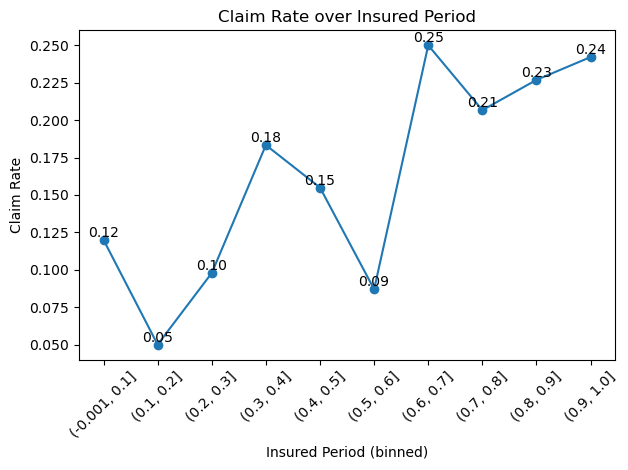

In [68]:
# Bin insured period
df['Insured_bin'] = pd.cut(df['Insured_Period'], bins=10)

# Claim rate per bin
claim_rate = df.groupby('Insured_bin')['Claim'].mean()

plt.figure()
plt.plot(range(len(claim_rate)), claim_rate.values, marker='o')
plt.xlabel('Insured Period (binned)')
plt.ylabel('Claim Rate')
plt.title('Claim Rate over Insured Period')

# Add values on the plot
for i, v in enumerate(claim_rate.values):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.xticks(range(len(claim_rate)), claim_rate.index.astype(str), rotation=45)
plt.tight_layout()
plt.show()


The plot shows that claim rate generally increases as the insured period increases.

Buildings insured for a short duration tend to have lower claim probabilities.

Buildings insured for longer periods show higher exposure to risk, leading to increased claim likelihood.

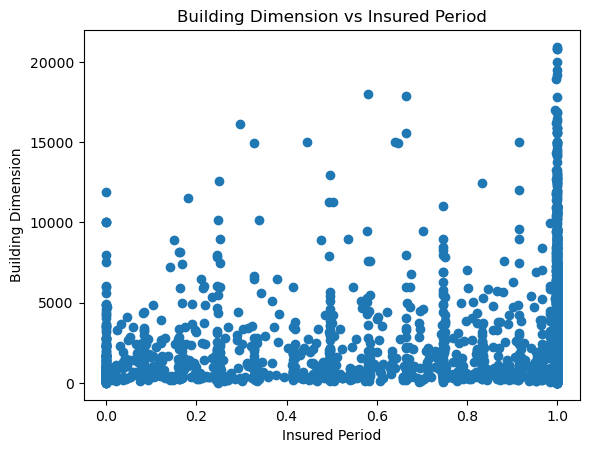

In [66]:
plt.figure()
plt.scatter(df['Insured_Period'], df['Building Dimension'])
plt.xlabel('Insured Period')
plt.ylabel('Building Dimension')
plt.title('Building Dimension vs Insured Period')
plt.show()



There is no strict linear relationship between insured period and building dimension.

Buildings of various sizes are insured for both short and long periods.

A few large buildings appear as outliers, especially at longer insured periods.

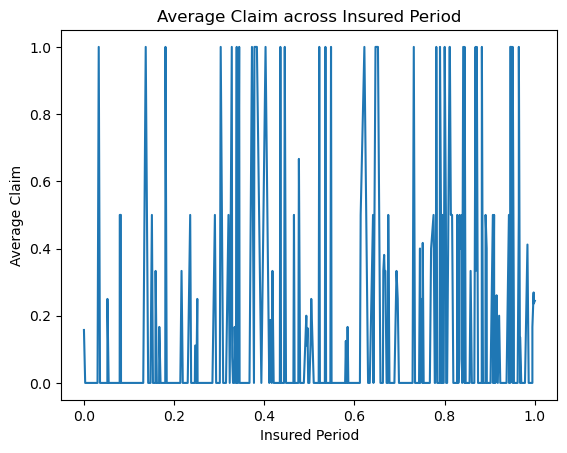

In [65]:

# Average claim by insured period
avg_claim = df.groupby('Insured_Period')['Claim'].mean().sort_index()

plt.figure()
plt.plot(avg_claim.index, avg_claim.values)
plt.xlabel('Insured Period')
plt.ylabel('Average Claim')
plt.title('Average Claim across Insured Period')
plt.show()


The average claim probability tends to rise with increasing insured period.

Small fluctuations are observed due to fewer observations at some insured-period values.

The overall trend supports a positive relationship between insured duration and claim occurrence.

In [39]:
le = LabelEncoder()
if 'Geo_Code' in df.columns and df['Geo_Code'].dtype == 'object':
    df['Geo_Code'] = le.fit_transform(df['Geo_Code'])

categorical_cols_to_encode = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement']
existing_categorical_cols = [col for col in categorical_cols_to_encode if col in df.columns]

if existing_categorical_cols:
    df = pd.get_dummies(
        df,
        columns=existing_categorical_cols,
        drop_first=True
    )

In [40]:
# confirming encoded label 
df.isna().sum()

YearOfObservation     0
Insured_Period        0
Residential           0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
Claim                 0
Building_Painted_V    0
Building_Fenced_V     0
Garden_V              0
Settlement_U          0
dtype: int64

In [41]:
# Changing Number Of Windows Datatype from float to integer 
df['NumberOfWindows'] = (
    df['NumberOfWindows']
    .astype(str)
    .str.strip()
    .replace('.', np.nan)
)

df['NumberOfWindows'] = pd.to_numeric(
    df['NumberOfWindows'], errors='coerce'
).fillna(0).astype(int)

df.head()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,Building_Painted_V,Building_Fenced_V,Garden_V,Settlement_U
0,2013,1.0,0,290.0,1,1960.0,0,7,0,False,True,True,True
1,2015,1.0,0,490.0,1,1850.0,4,7,0,True,False,False,False
2,2014,1.0,0,595.0,1,1960.0,0,7,0,False,True,True,True
3,2013,1.0,0,2840.0,1,1960.0,0,7,0,True,True,True,True
4,2014,1.0,0,680.0,1,1800.0,3,7,0,True,False,False,False


In [42]:
# checking correlation of numerical columns with the actual target (Claim)
# Define numeric_cols for correlation analysis, excluding the target 'Churn'.
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].corr()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
YearOfObservation,1.000000,0.025434,-0.040391,0.010959,0.005490,-0.030230,0.105646,-0.000965,-0.016367
Insured_Period,0.025434,1.000000,-0.037620,0.008822,-0.017811,-0.010523,0.040997,0.000324,0.088715
Residential,-0.040391,-0.037620,1.000000,0.056357,0.334039,-0.036885,0.130181,0.313912,0.063509
Building Dimension,0.010959,0.008822,0.056357,1.000000,0.009184,0.196190,0.214564,0.000282,0.295558
Building_Type,0.005490,-0.017811,0.334039,0.009184,1.000000,-0.137001,0.119087,0.273611,0.112168
Date_of_Occupancy,-0.030230,-0.010523,-0.036885,0.196190,-0.137001,1.000000,-0.172487,0.010092,0.017781
NumberOfWindows,0.105646,0.040997,0.130181,0.214564,0.119087,-0.172487,1.000000,0.057193,0.115655
Geo_Code,-0.000965,0.000324,0.313912,0.000282,0.273611,0.010092,0.057193,1.000000,0.040443
Claim,-0.016367,0.088715,0.063509,0.295558,0.112168,0.017781,0.115655,0.040443,1.000000


In [43]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
corr_with_claim = corr_matrix['Claim'].sort_values(ascending=False)
print(corr_with_claim)

Claim                 1.000000
Building Dimension    0.295558
NumberOfWindows       0.115655
Building_Type         0.112168
Insured_Period        0.088715
Residential           0.063509
Geo_Code              0.040443
Date_of_Occupancy     0.017781
YearOfObservation    -0.016367
Name: Claim, dtype: float64


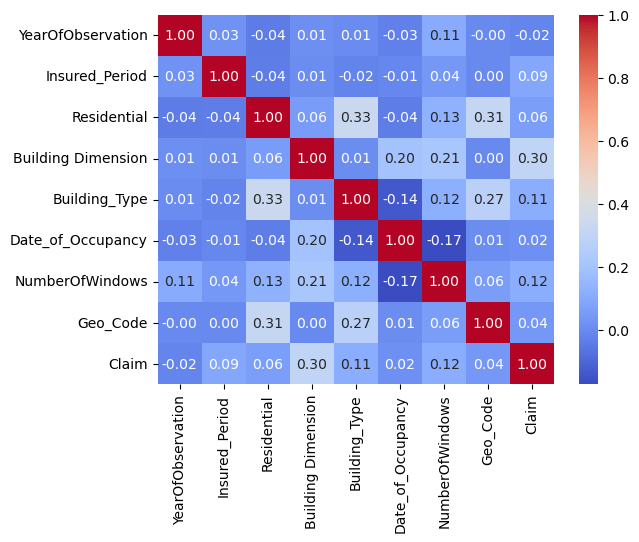

In [44]:
#Visualizing correlation of features with target
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt = '.2f', cmap = 'coolwarm')
plt.show()

The essence of correlation is to check to multicollinearity, redundant predictors and the relationship of numerical features with the actual target. Based on the visualization and correlated values seen above, it is observed that Building Dimension (0.3 approximately), Number of Windows (0.12 approximately) and Building Type(0.11) are most correlated features to the Claiming of an insured building.

After preprocessing, dataframe is separated into train-test split. This is where i will use 80% of the data to train excluding the main target feature (CLAIM) and use the remaining 20% of the data to test its perfornmance. Claim feature is excluded from the training so as to avoid near perfectness or overfitting of the trained data

In [45]:
# Splitting Data into Train-test split
X = df.drop('Claim', axis=1)  # Claim is dropped from the trained data
y = df['Claim']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [46]:
# Scaling up Features to ensure fairness amidst large and small features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Feature scaling is applied because Logistic Regression is sensitive to feature magnitude, and scaling ensures stable optimization, fair coefficient estimation, and faster convergence

Scaling puts all features on the same measurement scale so no variable unfairly dominates the model

In [47]:
log_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000
)

log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

print("\nLOGISTIC REGRESSION RESULTS\n")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))


LOGISTIC REGRESSION RESULTS

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1105
           1       0.37      0.53      0.44       327

    accuracy                           0.69      1432
   macro avg       0.61      0.63      0.61      1432
weighted avg       0.73      0.69      0.71      1432

ROC-AUC: 0.6860420385514827


From the result above, The logistic regression model predicts the majority class (0) well but struggles with the minority class (1).

ROC-AUC of 0.686 shows moderate discriminatory power.

The goal here is to identify Claim correctly but this model miss too many claims, capitalizing on the dominance of the no-claim, so there is need balancing strategies or using better models

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nRANDOM FOREST RESULTS\n")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))




RANDOM FOREST RESULTS

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1105
           1       0.41      0.43      0.42       327

    accuracy                           0.73      1432
   macro avg       0.62      0.62      0.62      1432
weighted avg       0.73      0.73      0.73      1432

ROC-AUC: 0.6871116830641926


The Random Forest model achieved an overall accuracy of 73%, showing a modest improvement over simpler models. It performs well on the majority class (Class 0) with high precision (0.83) and recall (0.82), indicating reliable predictions for non-positive cases.

However, performance on the minority class (Class 1) remains limited. While the model identifies 43% of actual positive cases (recall = 0.43), its precision (0.41) and F1-score (0.42) suggest a continued challenge in correctly predicting positive instances due to class imbalance.

The ROC-AUC score of 0.687 indicates fair discriminative ability, meaning the model is better than random guessing but still has room for improvement in separating the two classes

In [50]:
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.455  # try 0.3 – 0.4
y_pred_rf = (y_proba_rf >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1105
           1       0.38      0.50      0.43       327

    accuracy                           0.70      1432
   macro avg       0.61      0.63      0.61      1432
weighted avg       0.73      0.70      0.71      1432



The model shows reasonable performance with strong results for the majority class but limited effectiveness in identifying the minority class. While it captures 50% of positive cases, low precision indicates many false positives. Further improvement should focus on handling class imbalance and optimizing for minority class metrics rather than accuracy. To further improve this, i will try using other models and possibly hypertune the threshold so as to have increase in recall for the claim target. 

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate SMOTE
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=3,
    random_state=42
)

gb.fit(X_train_smote, y_train_smote)

y_proba = gb.predict_proba(X_test_scaled)[:,1]
y_pred = (y_proba >= 0.39).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1105
           1       0.39      0.50      0.44       327

    accuracy                           0.70      1432
   macro avg       0.61      0.63      0.62      1432
weighted avg       0.73      0.70      0.72      1432



The result of the GradientBoosting Classifier model still paid more attention to the majority class but there is a slight improvement to what can be seen for the actual target.  

In [56]:
from sklearn.model_selection import GridSearchCV
#Applying hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'subsample': [0.8, 1.0]
}


grid = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='f1',        
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_gb = grid.best_estimator_
print("Best Parameters:")
print(grid.best_params_)

weight_ratio = (y_train == 0).sum() / (y_train == 1).sum()
sample_weights = np.where(y_train == 1, weight_ratio, 1)

best_gb.fit(X_train, y_train, sample_weight=sample_weights)


# PREDICTIONS WITH CUSTOM THRESHOLD

y_proba = best_gb.predict_proba(X_test)[:, 1]

threshold = 0.5   
y_pred = (y_proba >= threshold).astype(int)


# EVALUATION

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1105
           1       0.38      0.53      0.44       327

    accuracy                           0.70      1432
   macro avg       0.61      0.64      0.62      1432
weighted avg       0.74      0.70      0.71      1432

Confusion Matrix:
[[826 279]
 [154 173]]
ROC-AUC: 0.6922689470989525


With the tuning of the threshold, there has been a slight increase in recall for claim cases which means with 53% recall and 70% accuracy of the actual target (Claim), it can be interpreted that despite the imbalances, it correctly identified over half of the  of the insured buildings that experienced at least one claim.
ROC-AUc of 69% indicates fair ability  to distinguish between claim and non-claim buildings. 

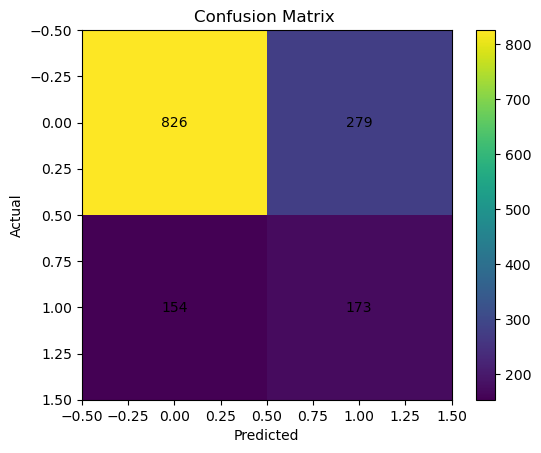

In [61]:
#Visualizing Confusion Matrix
cm = confusion_matrix(y_test,
y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

The confusion matrix chart confirms a meaningful number of the true claim detections

In summary, by combining imbalance-aware ensemble models with probabilyity based decision thresholds, the model effectively predicys whether a buildingis likely to experience at least one claim during the insured period.

So far, the best model to use (i.e with adequate threshold tuning) is the RandomForestClassifier model for the fair result it has over the Logistic regression model.

